In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys
import torch

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [17]:
def process_data(hdf5file, x_labels, y_labels, test:bool = False):

    data = h5py.File(hdf5file, "r")
    #print(data.keys())
    
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["xvalues"][:, i]).flatten()

    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    df["Confidence"] = data["confidence"]
    df["Predicted_color"] = "red"
    df_copy = df.copy()
    mask = df_copy["Confidence"] >= 0.5
    df.loc[mask, "Predicted_color"] = "blue"


    # Get truth label values (annoying because text is not read as text, should fix)
    if (test == False):
        df["Truth_value"] = data["truth"]
        blue = df["Truth_value"][len(df)-1]
        df["Truth"] = "red"
        df["Truth_int"] = 0
        #df["Truth"][df["Truth_value"] == green] = "blue"
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = "blue"
        df.loc[mask, "Truth_int"] = 1
    
    # Get estimated probabilities
    df["red"] = data["probabilities"][:,0]
    df["blue"] = data["probabilities"][:,1]
    df["P(blue|x)"] = data["probabilities"][:,1]

    # Get inferred color
    df["Inferred_color"] = df[["red", "blue"]].idxmax(axis=1)

    # Get error bars
    df["quantile25_red"] = data["quantiles"][:, 1, 0]
    df["quantile75_red"] = data["quantiles"][:, 2, 0]
    df["quantile25_green"] = data["quantiles"][:, 1, 1]
    df["quantile75_green"] = data["quantiles"][:, 2, 1]
    
    # Errors are the same
    df["Error"] = df["quantile75_red"] - df["quantile25_red"]
    #df["Error_green"] = df["quantile75_green"] - df["quantile25_green"]
    return df


In [18]:
def plot_data(df, ax, suptitle):
    ax.set_title(suptitle)
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_green = df[df["color"] == "blue"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    #legacy
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax

In [19]:
def plot_results(df, pred_key, ax, suptitle, grid=False, error=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if error:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax
    


In [20]:
def plot_uncertainties(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")

    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["Error"], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                cmap = "viridis")
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Error", 
                    #hue_norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                    #size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                    legend=False)
    
    #ax.set_xlim(-25, 25)
    #ax.set_ylim(-25, 25)

    return ax
    

In [21]:
n_data = [900, 2100, 2700, 3600]
ncal = 250
y_labels = ["red", "blue"]
x_labels = ["x1", "x2"]
label_index = [0, 1]
#ml_datafiles = "../DNN/predictions/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-2100.csv"
cal_datafiles = [f"calibrate/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}/nsamples-1200_nchains-20_ndata-{ncal}_calibrated/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}_inferred.h5" for n in n_data]
grid_datafiles = [f"calibrate/val_n_5000_kr7_kg3_s1_vary_a1_False_predicted_SequentialNet_ndata-{n}/nsamples-1200_nchains-20_ndata-{ncal}_calibrated/grid_predicted_SequentialNet_ndata-{n}_inferred.h5" for n in n_data]
trainfile = "train_n_5000_kr7_kg3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kg3_s1_vary_a1_False"
truthfile = "analytical_solution_x1_x2_grid_kr7_kb3_vary_a1_False_nxMC_100_nr1MC_50.csv"
truth_data = pd.read_csv(f"../analytical/{truthfile}")
train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")

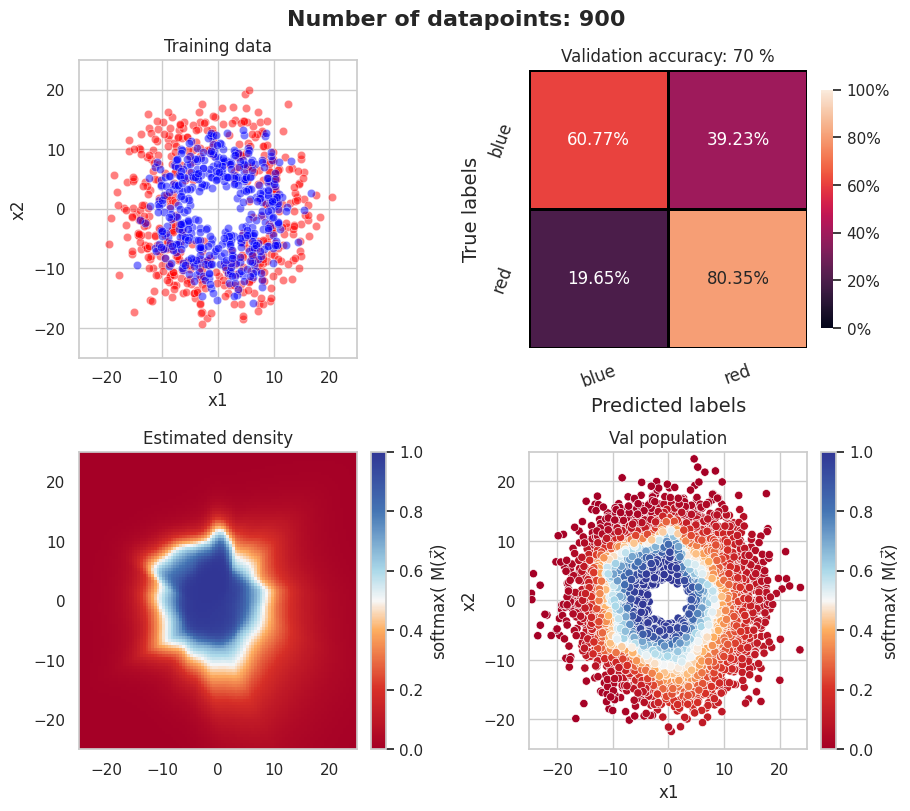

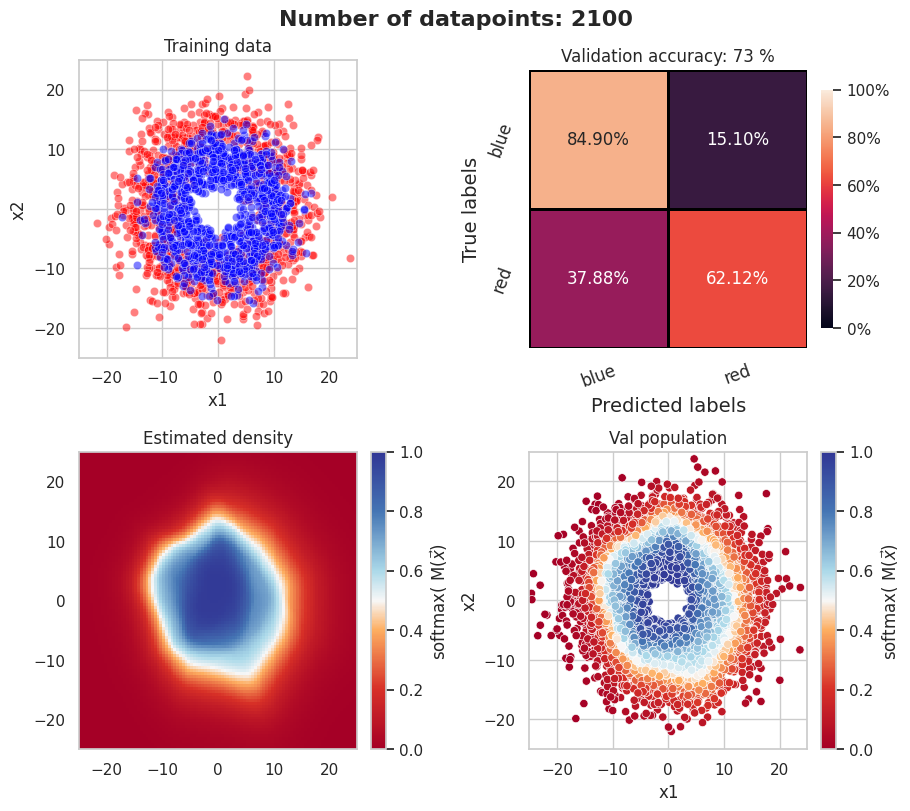

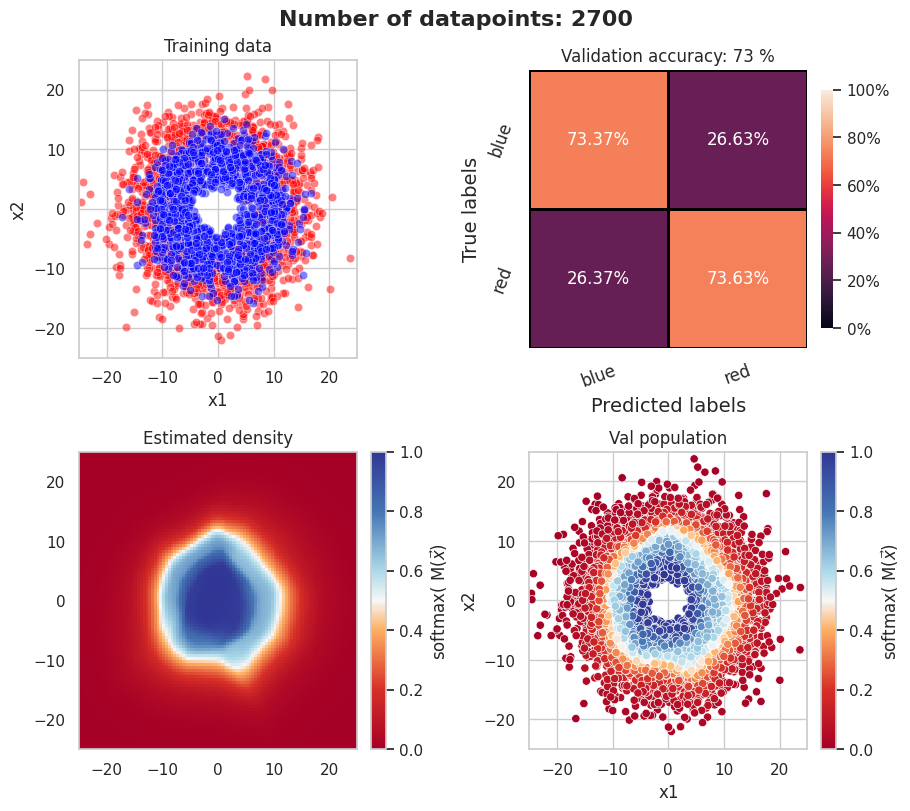

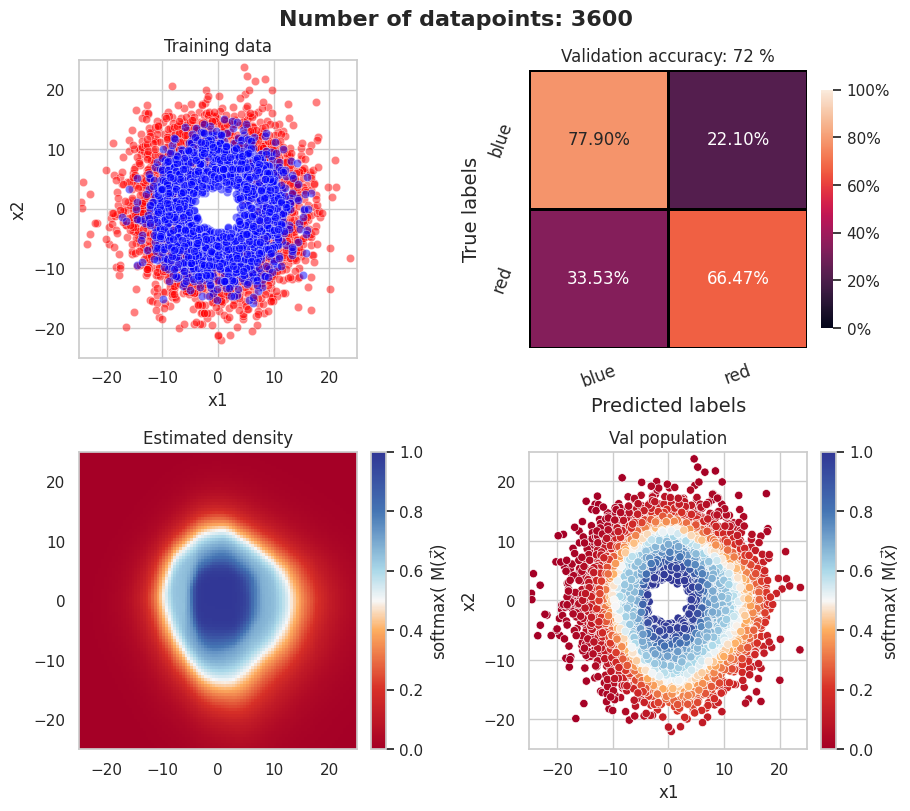

In [22]:

# Plot animation
val_dfs = [0]*len(n_data)
test_dfs = [0]*len(n_data)

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8), layout="constrained")
    df_val = process_data(cal_datafiles[i], x_labels, y_labels)
    df_test = process_data(grid_datafiles[i], x_labels, y_labels, test=True)
    val_dfs[i] = df_val
    test_dfs[i] = df_test
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0], "Training data")
    axs[0][1] = plot_conf_matrix(df_val, "Truth", "Predicted_color", ["blue", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, "Confidence", axs[1][0], "Estimated density", grid=True)
    axs[1][1] = plot_results(df_val, "Confidence", axs[1][1], "Val population", error=False)
    #axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Error test points", grid=True)
    #axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Error train data")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])
    #hue_norm_error = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_error, cmap="viridis"), label=r'Error', ax=axs[2][0])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "blue"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")
    #lt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

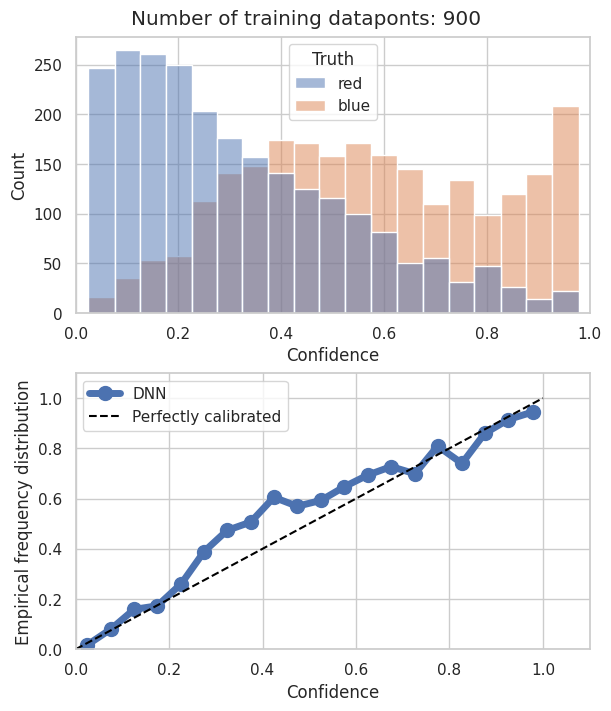

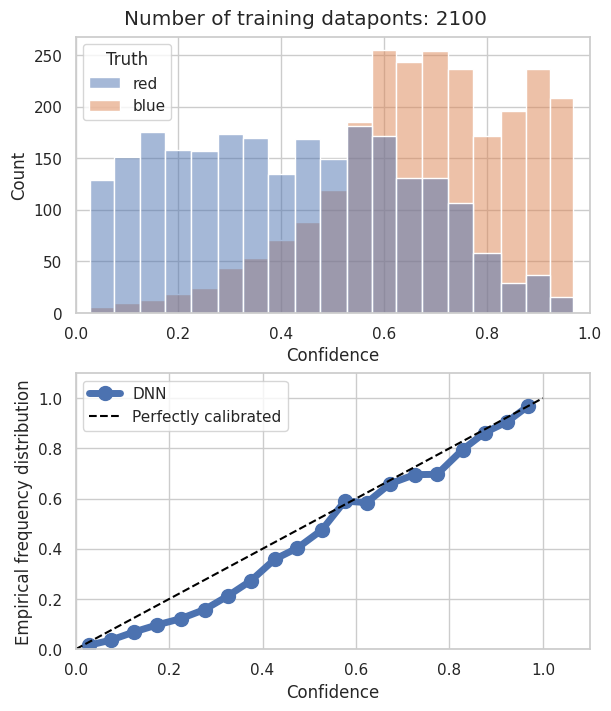

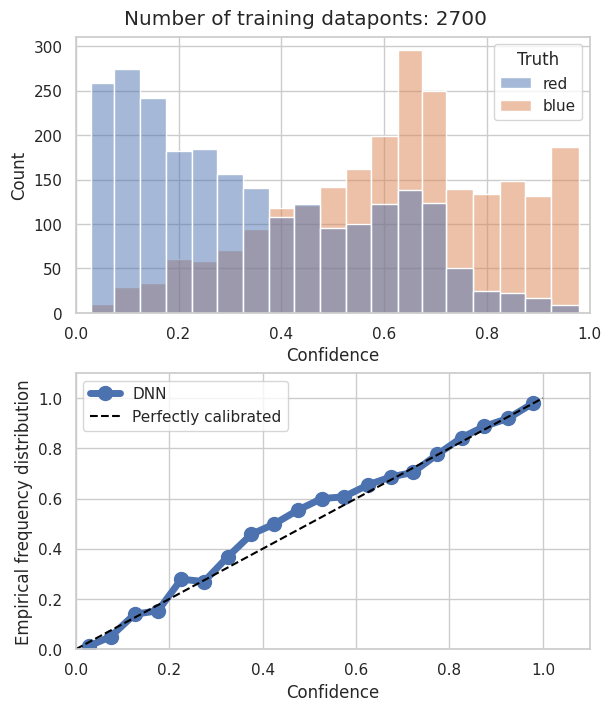

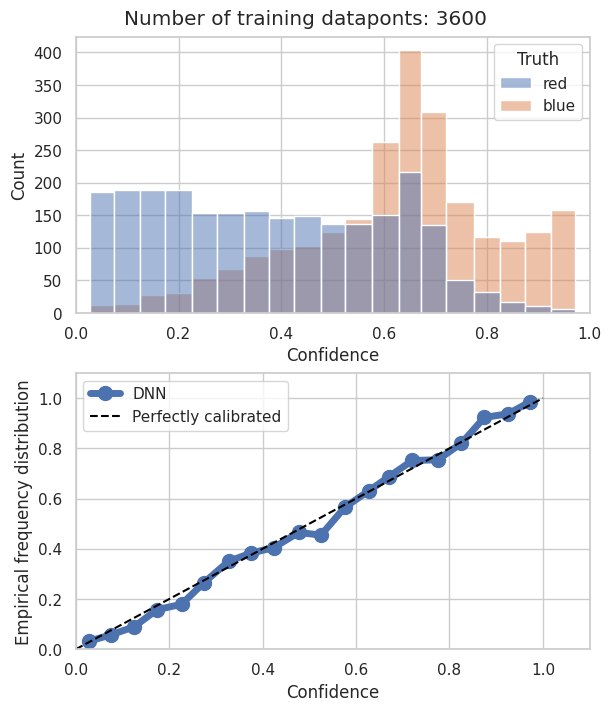

In [23]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_data)):
    #Get confidence for red

    prob_cal, prob_pred = calibration_curve(val_dfs[i]["Truth_int"], val_dfs[i]["Confidence"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(val_dfs[i], x="Confidence", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("Confidence")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of training dataponts: {n_data[i]}")


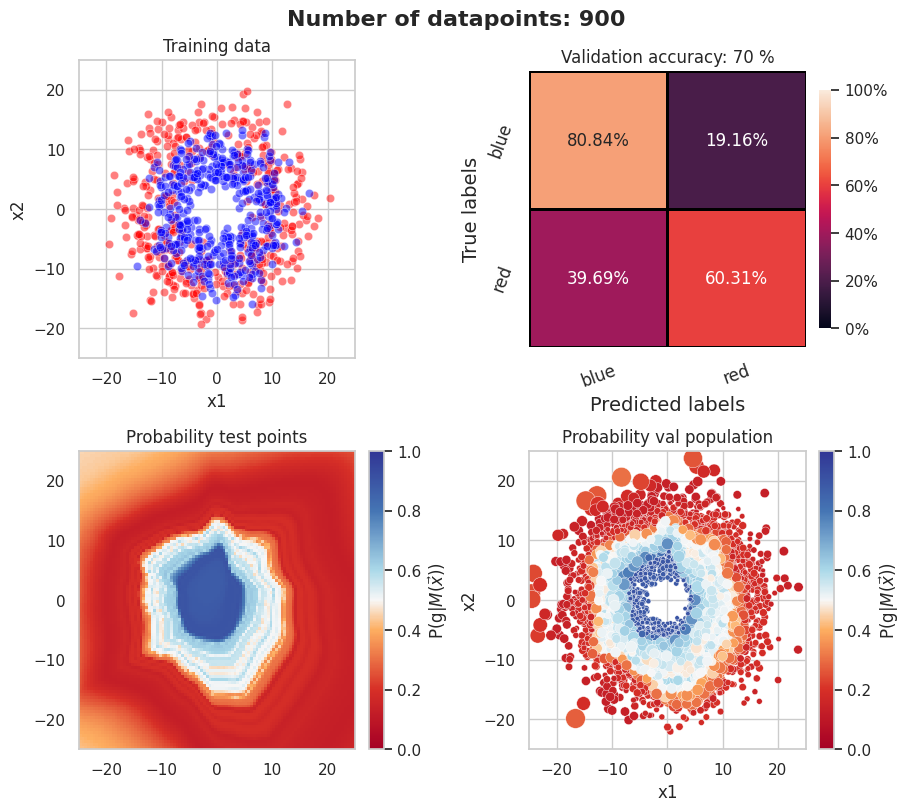

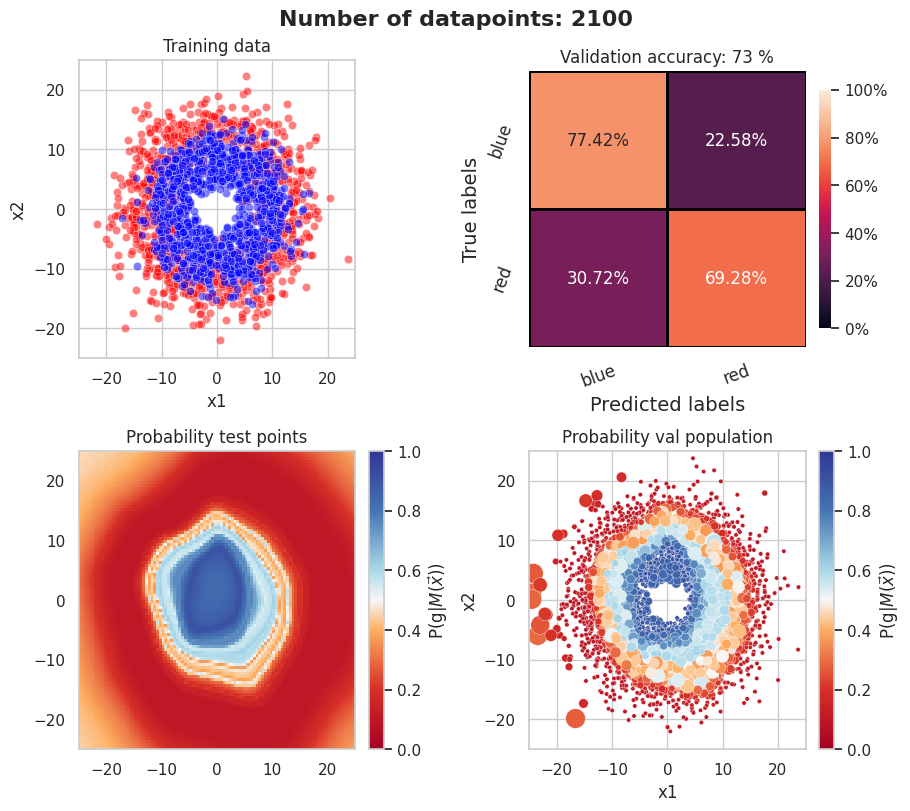

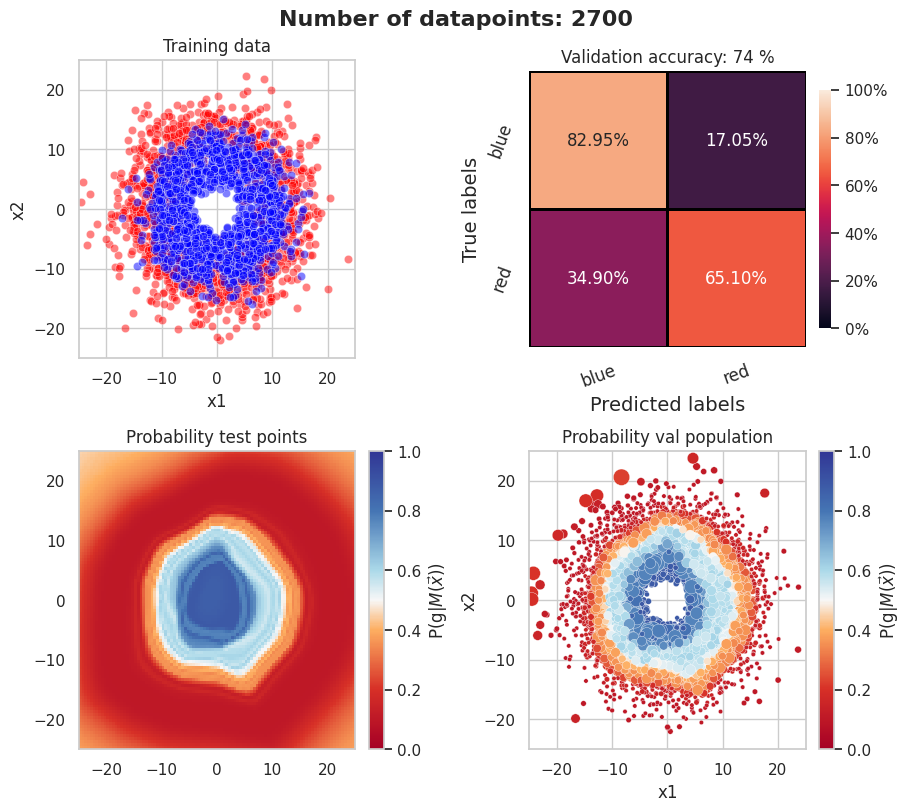

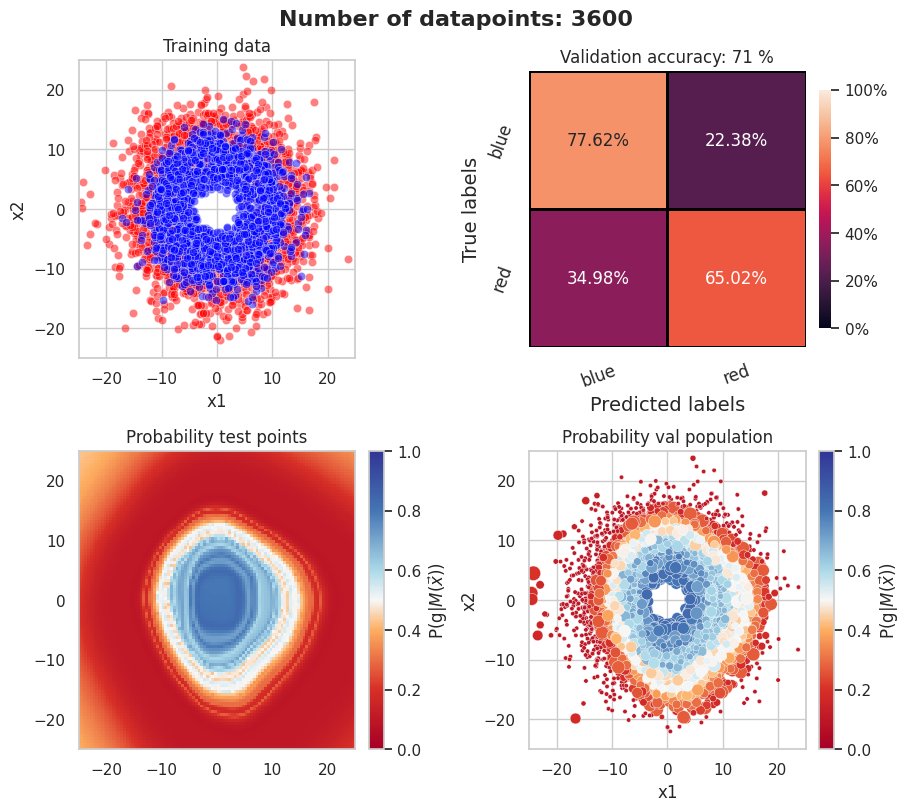

In [24]:

# Plot animation

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8), layout="constrained")
    df_val = process_data(cal_datafiles[i], x_labels, y_labels, test=False)
    df_test = process_data(grid_datafiles[i], x_labels, y_labels, test=True)
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0], "Training data")
    axs[0][1] = plot_conf_matrix(df_val, "Truth", "Inferred_color", ["blue", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, "P(blue|x)", axs[1][0], "Probability test points", grid=True)
    axs[1][1] = plot_results(df_val, "P(blue|x)", axs[1][1], "Probability val population", error=True)
    #axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Error test points", grid=True)
    #axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Error train data")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$M(\vec{x})$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$M(\vec{x})$)', ax=axs[1][1])
    #hue_norm_error = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False)
    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_error, cmap="viridis"), label=r'Error', ax=axs[2][0])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "blue"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")
    #lt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

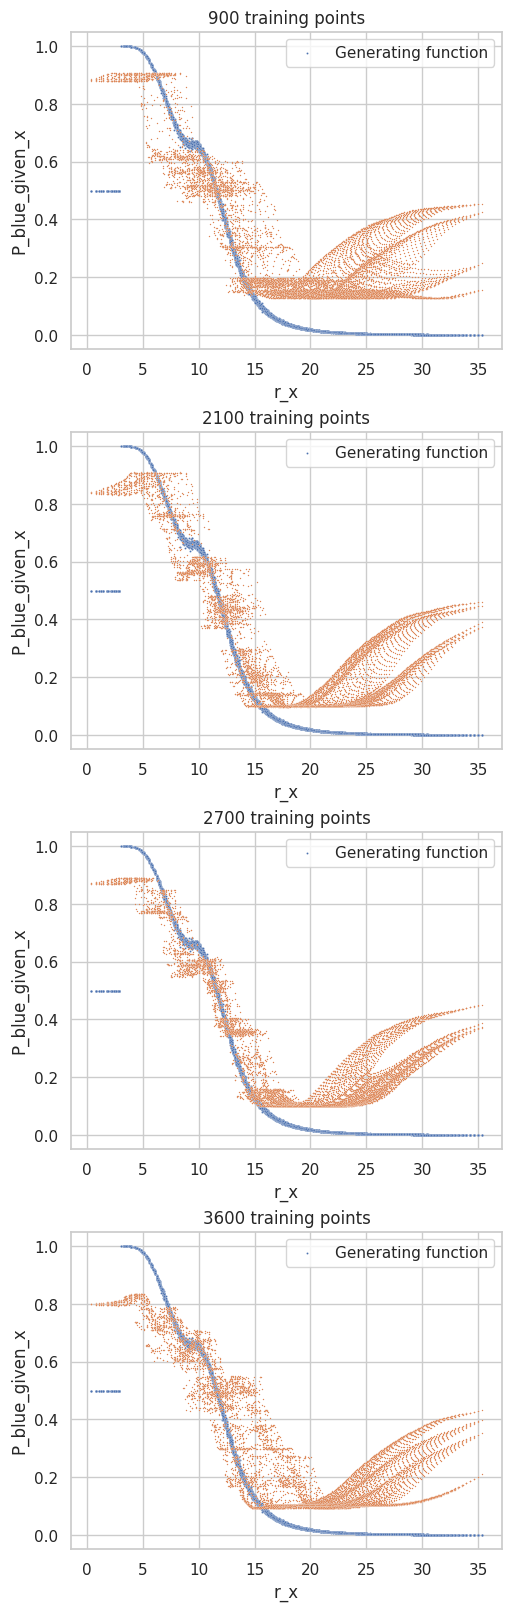

In [25]:
fig, axs = plt.subplots(nrows=len(n_data), ncols=1, figsize= (5, 4*len(n_data)), layout="constrained")
for i in range(len(n_data)):
    df_test = process_data(grid_datafiles[i], x_labels, y_labels, test=True)
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[i], label="Generating function")
    sn.scatterplot(df_test, x="r_x", y="P(blue|x)", s=1, ax = axs[i])
    axs[i].set_title(f"{n_data[i]} training points")


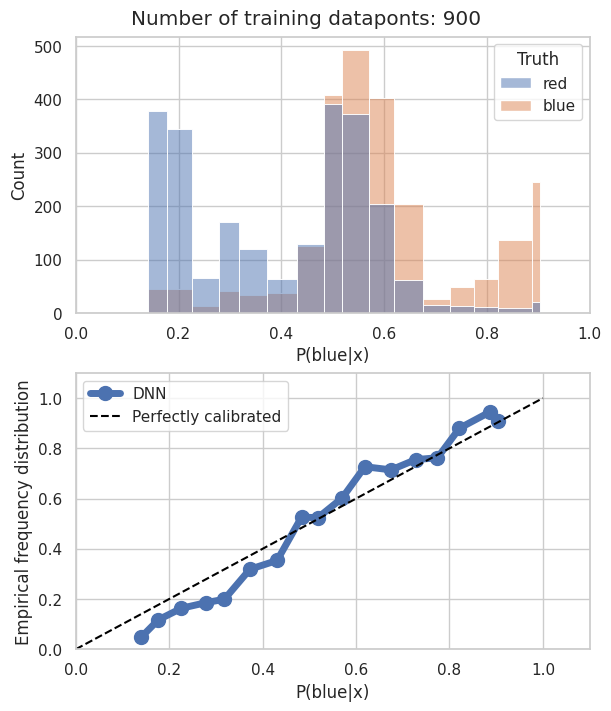

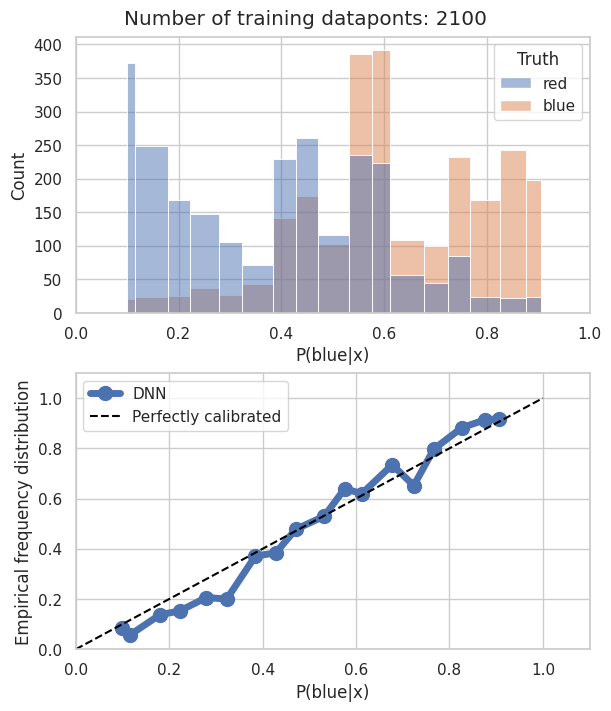

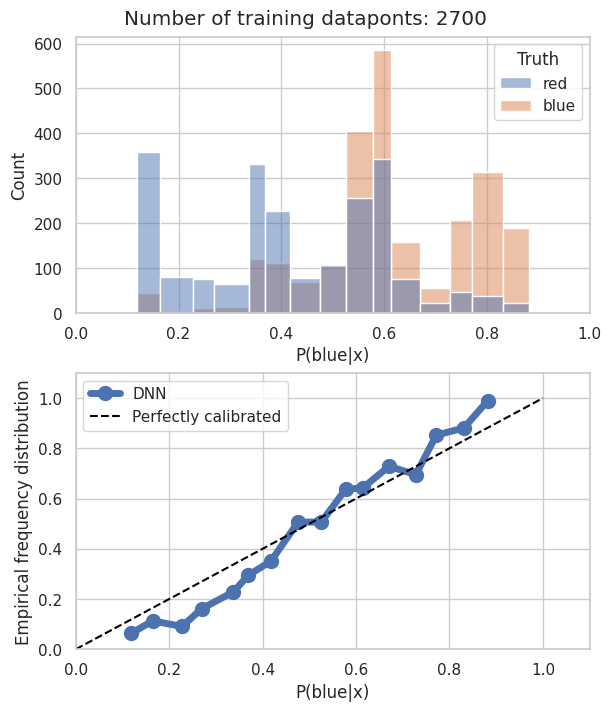

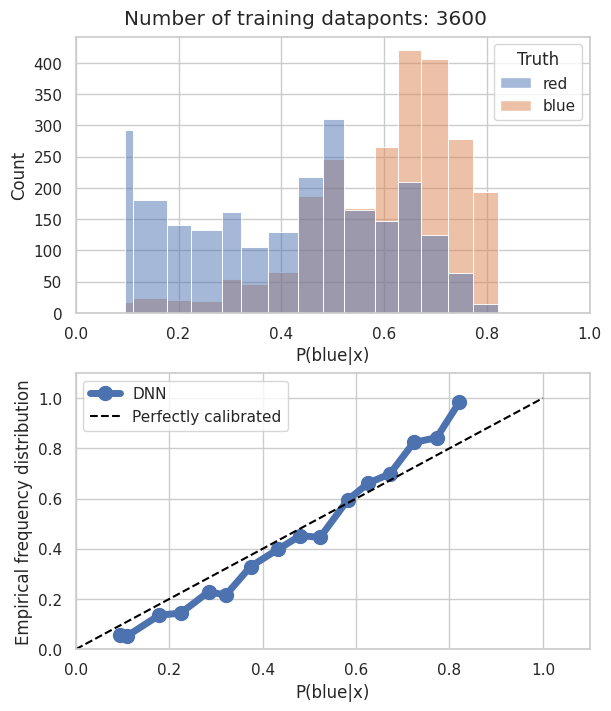

In [26]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(len(n_data)):
    #Get confidence for red
    cal_data = process_data(cal_datafiles[i], y_labels, x_labels)

    prob_cal, prob_pred = calibration_curve(cal_data["Truth_int"], cal_data["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(cal_data, x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of training dataponts: {n_data[i]}")

Text(0, 0.5, 'Probability')

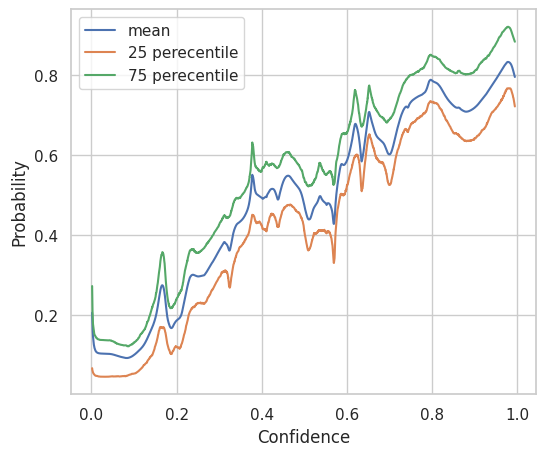

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
sn.lineplot(cal_data, x="Confidence", y="blue", label="mean", ax=ax)
sn.lineplot(cal_data, x="Confidence", y="quantile25_green", label = "25 perecentile", ax=ax)
sn.lineplot(cal_data, x="Confidence", y="quantile75_green", label = "75 perecentile", ax=ax)
ax.legend()
ax.set_ylabel("Probability")

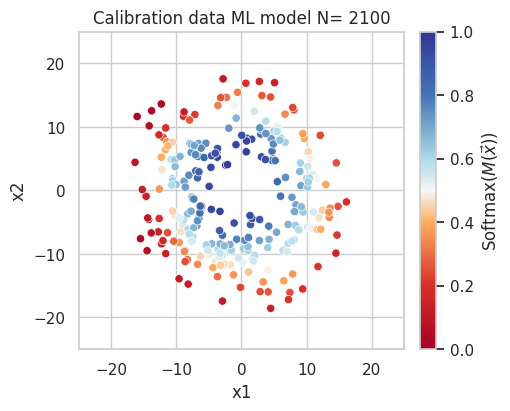

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 4), layout="constrained")

df_val = process_data(cal_datafiles[1], x_labels, y_labels, test=False)

plot_results(df_val[0:ncal], "Confidence", ax, f"Calibration data ML model N= {n_data[1]}", error=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Softmax($M(\vec{x})$)', ax=ax)

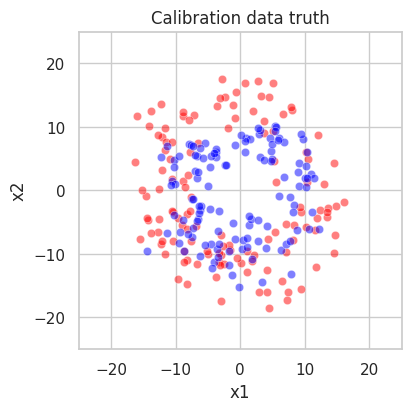

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), layout="constrained")
c = ["darkred","red","lightcoral","grey", "palegreen","blue","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)

ax = plot_data(val_data[0:ncal], ax, "Calibration data truth")